<a href="https://colab.research.google.com/github/ChinmayaKolhe/Hemifacial_spasm_Detection/blob/main/final_hemifacialSpasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, shutil, zipfile, glob, csv, random
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

# Paths
drive_dataset_path = "/content/drive/MyDrive/datasets/new_dataset"  # expected: train/normal, train/spasm, test/normal, test/spasm
zip_path = "/content/drive/MyDrive/datasets/new_dataset.zip"
local_dataset_path = "/content/dataset"
processed_base = "/content/processed_halves"  # will store left/right halves and metadata CSVs

# Extract dataset if needed
if not os.path.exists(drive_dataset_path):
    print("Extracting dataset to Drive for the first time...")
    os.makedirs("/content/drive/MyDrive/datasets", exist_ok=True)
    assert os.path.exists(zip_path), f"Zip not found at {zip_path}"
    !unzip -q "{zip_path}" -d "/content/drive/MyDrive/datasets"
else:
    print("✅ Dataset already extracted in Drive")

# Symlink to /content/dataset
if not os.path.exists(local_dataset_path):
    os.symlink(drive_dataset_path, local_dataset_path)
    print("Linked Drive dataset to /content/dataset")

print("Dataset ready at:", local_dataset_path)
!ls -R "{local_dataset_path}"

Mounted at /content/drive
✅ Dataset already extracted in Drive
Linked Drive dataset to /content/dataset
Dataset ready at: /content/dataset
/content/dataset:
test  train

/content/dataset/test:
normal	spasm

/content/dataset/test/normal:
'1 (1).jpeg'  '1 (2).jpg'   '1 (3).png'   '1 (5).jpeg'	'1 (6).jpg'
'1 (1).jpg'   '1 (2).png'   '1 (4).jpeg'  '1 (5).jpg'	'1 (6).png'
'1 (1).png'   '1 (3).jpeg'  '1 (4).jpg'   '1 (5).png'	'1 (7).jpeg'
'1 (2).jpeg'  '1 (3).jpg'   '1 (4).png'   '1 (6).jpeg'	'1 (7).jpg'

/content/dataset/test/spasm:
12.jpg	16.jpeg  23.jpg  25_aug_basic_transform_009.jpg
13.jpg	22.jpeg  24.png

/content/dataset/train:
normal	spasm

/content/dataset/train/normal:
'1 (100).jpg'  '1 (147).jpg'  '1 (222).jpg'  '1 (301).jpg'  '1 (62).jpeg'
'1 (100).png'  '1 (147).png'  '1 (223).jpg'  '1 (302).jpg'  '1 (62).jpg'
'1 (101).jpg'  '1 (148).jpg'  '1 (224).jpg'  '1 (30).jpeg'  '1 (62).png'
'1 (101).png'  '1 (148).png'  '1 (225).jpg'  '1 (30).jpg'   '1 (63).jpeg'
'1 (102).jpg'  '1 (149).

In [ ]:
# First, restart your runtime (Runtime -> Restart runtime) then run this:

!pip install --upgrade pip
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.14
!pip install protobuf==3.20.3

print("Installation completed. Now running the face detection code...")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 69.6 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [mediapipe]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompa

  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.14 requires protobuf<5,>=4.25.3, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.


Installation completed. Now running the face detection code...


In [ ]:
# CELL 2: Preprocessing – face crop + split into left/right halves

import os
import cv2
import csv
import glob
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
import mediapipe as mp

IMG_SIZE = 224
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

mp_face = mp.solutions.face_detection

# --- Helper Functions ---
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def detect_face_bbox_bgr(image_bgr):
    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5) as fd:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        results = fd.process(image_rgb)
        if not results.detections:
            return None
        det = max(results.detections, key=lambda d: d.score[0])
        bbox = det.location_data.relative_bounding_box
        h, w = image_bgr.shape[:2]
        x = int(max(0, bbox.xmin) * w)
        y = int(max(0, bbox.ymin) * h)
        bw = int(min(1.0, bbox.xmin + bbox.width) * w) - x
        bh = int(min(1.0, bbox.ymin + bbox.height) * h) - y
        cx, cy = x + bw // 2, y + bh // 2
        side = int(max(bw, bh) * 1.4)
        x0 = max(0, cx - side // 2)
        y0 = max(0, cy - side // 2)
        x1 = min(w, x0 + side)
        y1 = min(h, y0 + side)
        return x0, y0, x1, y1

def center_square_crop(image_bgr):
    h, w = image_bgr.shape[:2]
    side = min(h, w)
    y0 = (h - side) // 2
    x0 = (w - side) // 2
    return x0, y0, x0 + side, y0 + side

def process_and_split_image(src_path, dst_left_path, dst_right_path):
    img = cv2.imread(src_path)
    if img is None:
        return False
    bbox = detect_face_bbox_bgr(img)
    if bbox is None:
        bbox = center_square_crop(img)
    x0, y0, x1, y1 = bbox
    face = img[y0:y1, x0:x1]
    if face.size == 0:
        face = img
    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    mid = face.shape[1] // 2
    left_half, right_half = face[:, :mid, :], face[:, mid:, :]
    ensure_dir(os.path.dirname(dst_left_path))
    ensure_dir(os.path.dirname(dst_right_path))
    cv2.imwrite(dst_left_path, left_half, [cv2.IMWRITE_JPEG_QUALITY, 95])
    cv2.imwrite(dst_right_path, right_half, [cv2.IMWRITE_JPEG_QUALITY, 95])
    return True

def build_processed_dataset(raw_root, processed_root):
    splits = ["train", "test"]
    classes = ["normal", "spasm"]
    ensure_dir(processed_root)
    for split in splits:
        meta_rows = []
        for cls in classes:
            src_dir = os.path.join(raw_root, split, cls)
            if not os.path.isdir(src_dir):
                print(f"Warning: missing {src_dir}")
                continue
            img_paths = []
            for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"):
                img_paths.extend(glob.glob(os.path.join(src_dir, ext)))
            img_paths.sort()
            for p in tqdm(img_paths, desc=f"Processing {split}/{cls}", unit="img"):
                base = Path(p).stem
                dst_left = os.path.join(processed_root, split, cls, f"{base}_left.jpg")
                dst_right = os.path.join(processed_root, split, cls, f"{base}_right.jpg")
                ok = process_and_split_image(p, dst_left, dst_right)
                if ok:
                    meta_rows.append([dst_left, dst_right, cls, 0 if cls == "normal" else 1])
        csv_path = os.path.join(processed_root, f"metadata_{split}.csv")
        with open(csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["left_path", "right_path", "label", "int_label"])
            writer.writerows(meta_rows)
        print(f"Wrote {csv_path} with {len(meta_rows)} samples.")


processed_base = "/content/drive/MyDrive/datasets/processed_faces"
build_processed_dataset(local_dataset_path, processed_base)


Processing train/spasm: 100%|██████████| 396/396 [06:30<00:00,  1.01img/s]


Wrote /content/drive/MyDrive/datasets/processed_faces/metadata_train.csv with 926 samples.


Processing test/spasm: 100%|██████████| 7/7 [00:05<00:00,  1.18img/s]


Wrote /content/drive/MyDrive/datasets/processed_faces/metadata_test.csv with 27 samples.


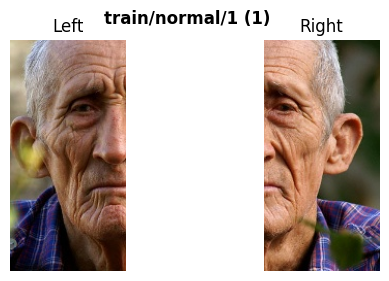

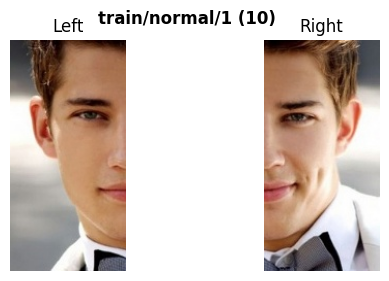

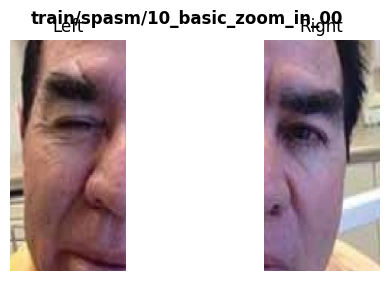

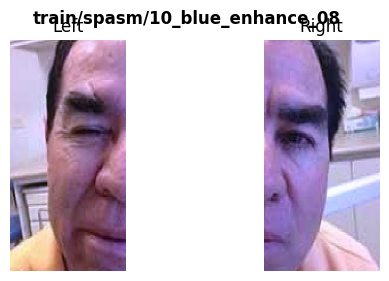

In [ ]:
# CELL 3: Quick sanity check – show sample left/right halves
import matplotlib.pyplot as plt
from PIL import Image

def show_samples(processed_root, split="train", cls="spasm", n=3):
    sample_dir = os.path.join(processed_root, split, cls)
    lefts = sorted(glob.glob(os.path.join(sample_dir, "*_left.jpg")))
    rights = sorted(glob.glob(os.path.join(sample_dir, "*_right.jpg")))
    left_bases = {Path(p).stem.replace("_left",""): p for p in lefts}
    right_bases = {Path(p).stem.replace("_right",""): p for p in rights}
    common = sorted(set(left_bases.keys()).intersection(right_bases.keys()))[:n]
    for base in common:
        lpath, rpath = left_bases[base], right_bases[base]
        fig, ax = plt.subplots(1, 2, figsize=(6,3))
        ax[0].imshow(Image.open(lpath)); ax[0].set_title("Left"); ax[0].axis("off")
        ax[1].imshow(Image.open(rpath)); ax[1].set_title("Right"); ax[1].axis("off")
        plt.suptitle(f"{split}/{cls}/{base}", fontweight="bold")
        plt.show()

show_samples(processed_base, "train", "normal", n=2)
show_samples(processed_base, "train", "spasm", n=2)

In [ ]:
# CELL 4: tf.data pipelines for dual-input (left/right)
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def load_metadata_csv(csv_path):
    lefts, rights, labels = [], [], []
    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            lefts.append(row["left_path"])
            rights.append(row["right_path"])
            labels.append(int(row["int_label"]))
    return lefts, rights, np.array(labels, dtype=np.int32)

def decode_img(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# EfficientNetV2 preprocess (scale to [0,255] expected by preprocess_input)
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preprocess

def preprocess_efficientnet(img):
    # img in [0,1], convert to [0,255] then preprocess
    img255 = img * 255.0
    return effv2_preprocess(img255)

# Mild augmentations (applied per-branch)
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.05),
], name="data_augment")

def make_dual_input_dataset(csv_path, batch_size=16, shuffle=True, augment=False):
    left_paths, right_paths, labels = load_metadata_csv(csv_path)

    ds = tf.data.Dataset.from_tensor_slices((
        {"left_input_path": left_paths, "right_input_path": right_paths},
        labels
    ))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(labels), seed=RANDOM_SEED, reshuffle_each_iteration=True)

    def _load_and_process(features, label):
        left = decode_img(features["left_input_path"])
        right = decode_img(features["right_input_path"])
        left = tf.image.resize(left, (IMG_SIZE, IMG_SIZE))
        right = tf.image.resize(right, (IMG_SIZE, IMG_SIZE))
        if augment:
            left = data_augment(left)
            right = data_augment(right)
        left = preprocess_efficientnet(left)
        right = preprocess_efficientnet(right)
        return {"left_input": left, "right_input": right}, tf.cast(label, tf.float32)

    ds = ds.map(_load_and_process, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_csv = os.path.join(processed_base, "metadata_train.csv")
test_csv = os.path.join(processed_base, "metadata_test.csv")

BATCH_SIZE = 16
train_ds = make_dual_input_dataset(train_csv, BATCH_SIZE, shuffle=True, augment=True)
val_ds   = make_dual_input_dataset(test_csv,  BATCH_SIZE, shuffle=False, augment=False)  # using test as val for simplicity; if you have val split, use that instead
test_ds  = make_dual_input_dataset(test_csv,  BATCH_SIZE, shuffle=False, augment=False)

# Class weights for imbalance
train_lefts, train_rights, train_labels = load_metadata_csv(train_csv)
neg = int((1 - np.array(train_labels)).sum())
pos = int(np.array(train_labels).sum())
total = max(1, neg + pos)
w0 = total / (2.0 * max(1, neg))
w1 = total / (2.0 * max(1, pos))
class_weight = {0: w0, 1: w1}
print("Class counts -> normal:", neg, "spasm:", pos, "| class_weight:", class_weight)

Class counts -> normal: 530 spasm: 396 | class_weight: {0: 0.8735849056603774, 1: 1.1691919191919191}


In [ ]:
# CELL 5: Dual-branch shared EfficientNetV2 model
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2B0

def build_dual_branch_model(img_size=IMG_SIZE, freeze_until=None):
    # Shared backbone (imagenet pretrained)
    backbone = EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_shape=(img_size, img_size, 3)
    )
    if freeze_until is None:
        for layer in backbone.layers:
            layer.trainable = False
    else:
        # freeze up to index (exclusive)
        for i, layer in enumerate(backbone.layers):
            layer.trainable = (i >= freeze_until)

    GAP = layers.GlobalAveragePooling2D()

    left_in = layers.Input(shape=(img_size, img_size, 3), name="left_input")
    right_in = layers.Input(shape=(img_size, img_size, 3), name="right_input")

    left_feat = GAP(backbone(left_in, training=False))
    right_feat = GAP(backbone(right_in, training=False))

    # Capture asymmetry
    abs_diff = layers.Lambda(lambda xs: tf.abs(xs[0] - xs[1]))([left_feat, right_feat])
    feat = layers.Concatenate()([left_feat, right_feat, abs_diff])

    x = layers.BatchNormalization()(feat)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", name="spasm_prob")(x)

    model = Model(inputs=[left_in, right_in], outputs=out, name="DualEffNetV2_Asymmetry")
    return model

model = build_dual_branch_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DualEffNetV2_Asymmetry"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ left_input[0][0], │
│ (Functional)        │ 1280)             │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1280)      │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3840)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3840)      │     15,360 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3840)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    983,296 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spasm_prob (Dense)  │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,919,249 (26.39 MB)

 Trainable params: 991,745 (3.78 MB)

 Non-trainable params: 5,927,504 (22.61 MB)

In [ ]:
# CELL 6: Train (frozen backbone) for initial epochs
EPOCHS_STAGE1 = 5  # first stage with frozen backbone
history1 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE1,
    validation_data=val_ds,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8927 - loss: 0.2889 - precision: 0.8704 - recall: 0.8884 - val_accuracy: 1.0000 - val_loss: 0.0820 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9510 - loss: 0.1019 - precision: 0.8986 - recall: 0.9791 - val_accuracy: 0.9259 - val_loss: 0.1067 - val_precision: 1.0000 - val_recall: 0.7143
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9851 - loss: 0.0396 - precision: 0.9751 - recall: 0.9907 - val_accuracy: 0.9630 - val_loss: 0.0738 - val_precision: 1.0000 - val_recall: 0.8571
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9831 - loss: 0.0390 - precision: 0.9730 - recall: 0.9882 - val_accuracy: 1.0000 - val_loss: 0.0495 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9958 - loss: 0.0143 - precision: 0.9932 - recall: 0.9974 - val_accuracy: 1.0000 - val_loss: 0.0069 - val

In [ ]:
# CELL 7: Fine-tune – unfreeze top of backbone and train a few more epochs
# Unfreeze top 30% of layers of backbone
backbone_layers = [l for l in model.layers if isinstance(l, tf.keras.Model)]
# find the EfficientNetV2 backbone by name
effnet = None
for l in model.layers:
    if isinstance(l, tf.keras.Model) and "efficientnetv2" in l.name.lower():
        effnet = l
        break

if effnet is None:
    # fetch from nested
    for l in model.layers:
        for sl in getattr(l, "layers", []):
            if isinstance(sl, tf.keras.Model) and "efficientnetv2" in sl.name.lower():
                effnet = sl
                break

if effnet is None:
    print("Warning: could not find backbone to unfreeze; skipping fine-tune")
else:
    n = len(effnet.layers)
    cutoff = int(n * 0.7)  # unfreeze last 30%
    for i, layer in enumerate(effnet.layers):
        layer.trainable = (i >= cutoff)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )

EPOCHS_STAGE2 = 3  # fine-tune epochs
history2 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE2,
    validation_data=val_ds,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9539 - loss: 0.1150 - precision: 0.9173 - recall: 0.9781 - val_accuracy: 1.0000 - val_loss: 0.0043 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.9636 - loss: 0.1024 - precision: 0.9263 - recall: 0.9837 - val_accuracy: 1.0000 - val_loss: 0.0021 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9870 - loss: 0.0509 - precision: 0.9828 - recall: 0.9861 - val_accuracy: 1.0000 - val_loss: 0.0042 - val_precision: 1.0000 - val_recall: 1.0000


Test metrics:
- loss: 0.0042
- compile_metrics: 1.0000

Derived metrics:
- F1: 1.0000
- ROC AUC: 1.0000
- PR AUC: 1.0000

Classification report:
              precision    recall  f1-score   support

      normal     1.0000    1.0000    1.0000        20
       spasm     1.0000    1.0000    1.0000         7

    accuracy                         1.0000        27
   macro avg     1.0000    1.0000    1.0000        27
weighted avg     1.0000    1.0000    1.0000        27



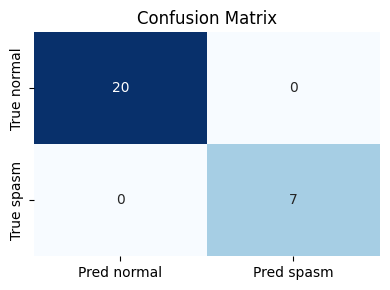

In [ ]:
# CELL 8: Evaluation – accuracy, precision, recall, F1, confusion matrix, report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
eval_results = model.evaluate(test_ds, verbose=0)
print("Test metrics:")
for name, val in zip(model.metrics_names, eval_results):
    print(f"- {name}: {val:.4f}")

# Predict labels
y_true = []
y_pred_prob = []
for batch in test_ds:
    x, y = batch
    probs = model.predict(x, verbose=0).reshape(-1)
    y_pred_prob.extend(probs.tolist())
    y_true.extend(y.numpy().astype(int).tolist())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Derived metrics
precision = ( (y_pred & y_true).sum() / max(1, y_pred.sum()) )
recall = ( (y_pred & y_true).sum() / max(1, y_true.sum()) )
f1 = 0.0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall)
try:
    roc_auc = roc_auc_score(y_true, y_pred_prob)
except:
    roc_auc = float("nan")
try:
    pr_auc = average_precision_score(y_true, y_pred_prob)
except:
    pr_auc = float("nan")

print(f"\nDerived metrics:")
print(f"- F1: {f1:.4f}")
print(f"- ROC AUC: {roc_auc:.4f}")
print(f"- PR AUC: {pr_auc:.4f}")

# Classification report
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["normal", "spasm"], digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred normal", "Pred spasm"],
            yticklabels=["True normal", "True spasm"])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Model saved to: /content/drive/MyDrive/hemifacial_spasm_model/dual_effnetv2_asymmetry.h5


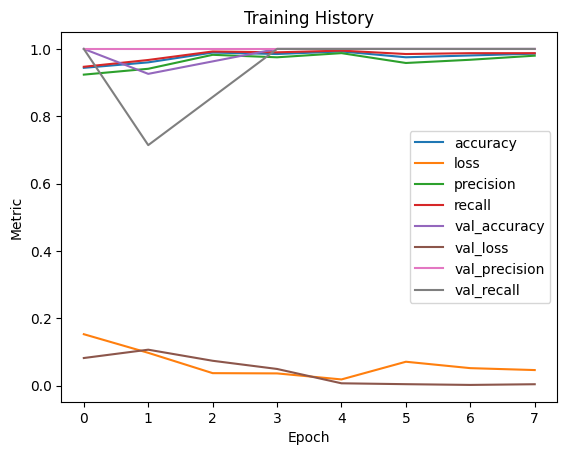

In [ ]:
# CELL 9: Save model and training curves
save_dir = "/content/drive/MyDrive/hemifacial_spasm_model"
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, "dual_effnetv2_asymmetry.h5"))
print("Model saved to:", os.path.join(save_dir, "dual_effnetv2_asymmetry.h5"))

# Plot training curves
def plot_history(h1, h2):
    def extract(hist):
        return {k: np.array(v) for k, v in hist.history.items()}

    h1d = extract(history1) if h1 is not None else {}
    h2d = extract(history2) if h2 is not None else {}
    keys = sorted(set(h1d.keys()) | set(h2d.keys()))
    for k in keys:
        v = []
        if k in h1d: v += list(h1d[k])
        if k in h2d: v += list(h2d[k])
        plt.plot(v, label=k)
    plt.legend()
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.show()

plot_history(history1, history2)

/content/dataset/test/normal/1 (1).jpeg
Prediction: NORMAL (prob=0.013)


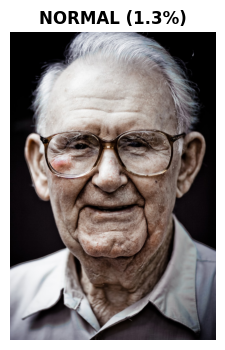

/content/dataset/test/normal/1 (1).jpg
Prediction: NORMAL (prob=0.001)


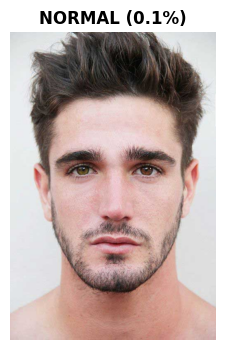

/content/dataset/test/normal/1 (1).png
Prediction: NORMAL (prob=0.002)


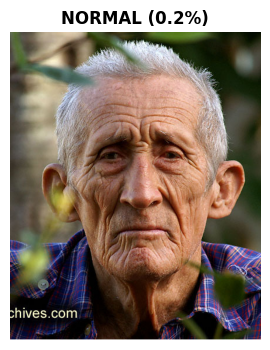

/content/dataset/test/normal/1 (2).jpeg
Prediction: NORMAL (prob=0.026)


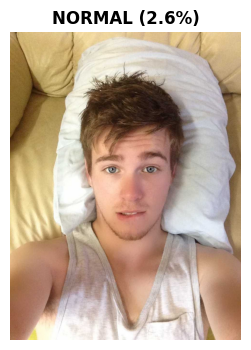

/content/dataset/test/normal/1 (2).jpg
Prediction: NORMAL (prob=0.006)


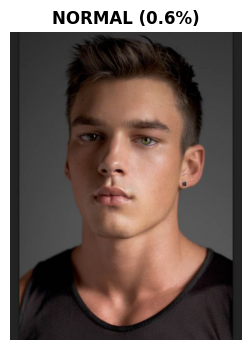

/content/dataset/test/spasm/12.jpg
Prediction: SPASM (prob=1.000)


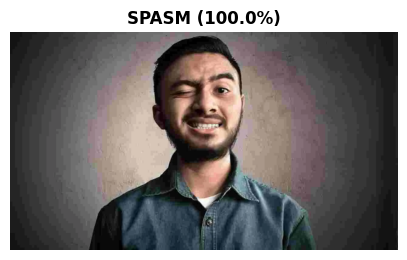

/content/dataset/test/spasm/13.jpg
Prediction: SPASM (prob=1.000)


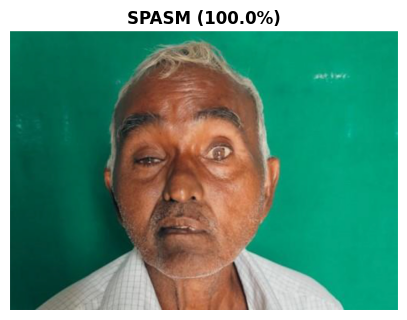

/content/dataset/test/spasm/16.jpeg
Prediction: SPASM (prob=1.000)


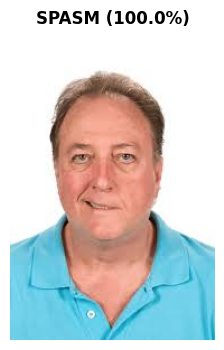

/content/dataset/test/spasm/22.jpeg
Prediction: SPASM (prob=0.993)


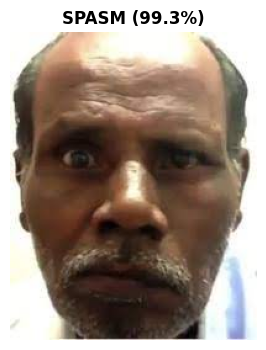

/content/dataset/test/spasm/23.jpg
Prediction: SPASM (prob=0.998)


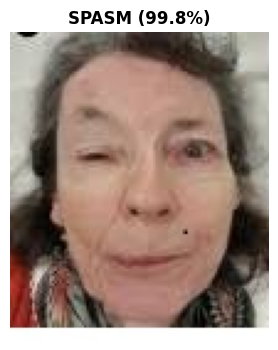

In [ ]:
# CELL 10: Single-image diagnosis function
def preprocess_single_image_for_model(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Cannot read image: {image_path}")
    bbox = detect_face_bbox_bgr(img)
    if bbox is None:
        bbox = center_square_crop(img)
    x0, y0, x1, y1 = bbox
    face = img[y0:y1, x0:x1]
    if face.size == 0:
        face = img
    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    mid = face.shape[1] // 2
    left = face[:, :mid, :]
    right = face[:, mid:, :]
    left = tf.image.convert_image_dtype(left, tf.float32)
    right = tf.image.convert_image_dtype(right, tf.float32)
    left = preprocess_efficientnet(left)
    right = preprocess_efficientnet(right)
    left = tf.expand_dims(left, 0)
    right = tf.expand_dims(right, 0)
    return {"left_input": left, "right_input": right}

def diagnose_image(image_path, threshold=0.5, show=True):
    batch = preprocess_single_image_for_model(image_path)
    prob = float(model.predict(batch, verbose=0).reshape(()))
    pred = int(prob >= threshold)
    label = "SPASM" if pred == 1 else "NORMAL"
    print(f"Prediction: {label} (prob={prob:.3f})")
    if show:
        img = Image.open(image_path)
        plt.figure(figsize=(5,4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{label} ({prob:.1%})", fontweight="bold")
        plt.show()
    return pred, prob

# Example: run on a few test images
example_images = []
for cls in ["normal", "spasm"]:
    dirp = os.path.join(local_dataset_path, "test", cls)
    example_images.extend(sorted(glob.glob(os.path.join(dirp, "*"))[:5]))

for p in example_images:
    print(p)
    diagnose_image(p)

Final test metrics:
              precision    recall  f1-score   support

      normal     1.0000    1.0000    1.0000        20
       spasm     1.0000    1.0000    1.0000         7

    accuracy                         1.0000        27
   macro avg     1.0000    1.0000    1.0000        27
weighted avg     1.0000    1.0000    1.0000        27



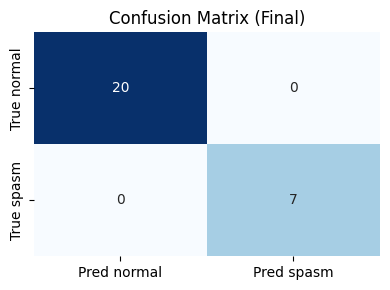

In [ ]:
# CELL 11: Batch prediction on test set with final summary metrics
def evaluate_on_testset():
    y_true = []
    y_prob = []
    for (features, labels) in test_ds:
        probs = model.predict(features, verbose=0).reshape(-1)
        y_prob.extend(probs.tolist())
        y_true.extend(labels.numpy().astype(int).tolist())
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    print("Final test metrics:")
    print(classification_report(y_true, y_pred, target_names=["normal", "spasm"], digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred normal", "Pred spasm"],
                yticklabels=["True normal", "True spasm"])
    plt.title("Confusion Matrix (Final)")
    plt.tight_layout()
    plt.show()

evaluate_on_testset()